In [ ]:
# This should allow automatically reading in the new modules as soon as the python file changes
# (Helpful for nbdev-generated modules, such as rfpfolio)
%load_ext autoreload
%autoreload 2

In [ ]:
#default_exp stats

In [ ]:
!pwd

/c/Users/USER/dev/notebooks/Financial/rfpfolio


In [ ]:
!ls testdata/2017-Apr

monthly
weekly


# stats

> Stats and analysis of portofolio performance

In [ ]:
#hide
from nbdev.showdoc import show_doc
from fastcore.test import *
from nbdev.export import notebook2script

In [ ]:
#export
import pandas as pd
import numpy as np
import os.path
from typing import NamedTuple
import datetime
import rfpfolio as rfp
import matplotlib.pyplot as plt

# Hide warning on import of empyrical
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    import empyrical.stats as estats

In [ ]:
%matplotlib inline

## Performance Statistics

In [ ]:
#exporti
def _ann_rate_to_period_rate(ann_rate, period='weekly'):
    """Convert annual return rate to periodic rate for the specified period ('daily', 'weekly', 'monthly').
    """
    return (1 + ann_rate)**(1/estats.annualization_factor(period, None)) - 1

In [ ]:
#hide
# Tests
monthly_rate = _ann_rate_to_period_rate(0.10, 'monthly')
test_close((1 + monthly_rate)**12, 1.10)

weekly_rate = _ann_rate_to_period_rate(0.12, 'weekly')
test_close((1 + weekly_rate)**52, 1.12)

daily_rate = _ann_rate_to_period_rate(0.06, 'daily')
test_close((1 + daily_rate)**252, 1.06)

In [ ]:
#export
def default_stats_spec(period='weekly', ann_rf_rate=0):
    """Generate specs for some standard statistics, given annual risk-free rate and return period of data."""
    per_rf_rate = _ann_rate_to_period_rate(ann_rf_rate, period)
    
    stats_spec = {'Annual Return':lambda x:estats.annual_return(x, period),
                  'Max Drawdown':estats.max_drawdown,
                  'Annual Volatility':lambda x: estats.annual_volatility(x, period), 
                  'Sharpe Ratio':lambda x: estats.sharpe_ratio(x, risk_free=per_rf_rate, period=period)}
    return stats_spec

In [ ]:
#export
def perfStatsRowTable(pf_returns, stats_spec, style=False):
    """
    Statistic per row; columns are portfolios.
    """
    valDict = {pf_col: [f(pf_returns[pf_col]) for f in stats_spec.values()] for pf_col in pf_returns.columns}
    
    if style:
        cm = sns.light_palette("pastel blue", reverse=True, as_cmap=True, input='xkcd')
    
    df = pd.DataFrame(valDict, index=stats_spec.keys())
    
    if style:
        return (df
                .style
                .background_gradient(cmap=cm, axis=1)
                .format("{:.2%}")
               )
    else:
        return df

Example application:

In [ ]:
# Some data to work with
src1 = rfp.PriceSource('testdata/2017-Apr', subdir_default='monthly')

In [ ]:
src1.list_return_dates()

2017-04-01 => 2020-06-01  AGG.csv
2017-04-01 => 2020-06-01  GLD.csv
2017-04-01 => 2020-06-01  IEI.csv
2017-04-01 => 2020-06-01  PDBC.csv
2017-04-01 => 2020-06-01  SHV.csv
2017-04-01 => 2020-06-01  SPY.csv
2017-04-01 => 2020-06-01  TLT.csv
2017-04-01 => 2020-06-01  VT.csv
2017-04-01 => 2020-06-01  VTI.csv


In [ ]:
pf_6040 = rfp.computePortfolioReturns(src1, [('IEI', .40), ('SPY', .60)], "Pf_6040", 
                                      rebal_period=3, period='monthly')

In [ ]:
perfStatsRowTable(pf_6040, default_stats_spec('monthly'))

,Pf_6040
Annual Return,0.082506
Max Drawdown,-0.102177
Annual Volatility,0.093022
Sharpe Ratio,0.900518


## Return and Volatility of Asset Combos

See how return/volatility vary with varying ratios of asset pairs.

This can be used, for example for "bullet plots" which show the efficient frontier of a pair of assets.

We would like to combine two return sequences. Assume that each return sequence is the output of `computePortfolioReturns()` (possibly a single-asset portfolio.)

In [ ]:
# Example: Interested in combining 60-40 portfolio with gold
pf_6040 = rfp.computePortfolioReturns(src1, [('IEI', .40), ('SPY', .60)], "Pf_6040", 
                                      rebal_period=3, period='monthly')
gold = rfp.computePortfolioReturns(src1, [('GLD', 1,)], "Gold", rebal_period=3, period='monthly')

In [ ]:
pf_6040.head(3)

,Pf_6040
Date,
2017-05-01,0.010199
2017-06-01,-0.000358
2017-07-01,0.016895


In [ ]:
gold.head(3)

,Gold
Date,
2017-05-01,-0.001242
2017-06-01,-0.021555
2017-07-01,0.023132


In [ ]:
#export

class DateRange(NamedTuple):
    start_date: datetime.date
    end_date: datetime.date

def ret_vol_combos(ret1, ret2, nsteps, period='monthly', rebal_period=3):
    """Return and volatility that results from combining two return series in proportions from 0 to 100%.
    
    Args:
     - ret1: return series 1 (sequence of period returns, such as output by computePortfolioReturns())
     - ret2: return series 2
     - nsteps: number of steps to take in allocation to the returns, between 0 and 100%
     - period: return interval in `ret1`, `ret2`: {'daily', 'weekly', 'monthly'}
     - rebal_period: interval for rebalancing the allocation; expressed as number of periods of type `period`
     
     Return:
      - Dataframe with results for each allocation between 0 and 100%
        - annualized return
        - annualized standard deviation
        - annualized downside deviation
      - Date range of returns used for these results
    """
    # convert period returns to wr's
    ret1 = ret1.copy() + 1
    ret2 = ret2.copy() + 1
    
    # combine the two return sequences
    combined = pd.concat([ret1, ret2], axis=1, join='inner')
    # Note: the concat/join ensures we have the same date range for both return sequences; 
    # computing the date range here ensures that it accurately reflects dates to compute results
    date_range = DateRange(min(combined.index).date(), max(combined.index).date())
    
    stepsize = 1 / nsteps
    return_list = []
    vol_list = []
    downside_list = []
    w1_list = []
    for ix in range(nsteps+1):
        w1 = 1 - ix*stepsize
        w2 = ix*stepsize
        res = rfp.pf_period_returns(combined, [w1, w2], rebal_period, f'combined_{w1:4.2}')
        # print(res.head())
        ann_ret = estats.annual_return(res.values, period=period)
        ann_vol = estats.annual_volatility(res.values, period=period)
        ann_downside = estats.downside_risk(res.values, period=period) # option to add `required_return` parameter
        #print(w1, w2, ann_ret, ann_vol)
        return_list.append(ann_ret[0])
        vol_list.append(ann_vol[0])
        downside_list.append(ann_downside[0])
        w1_list.append(w1)
        
    df = pd.DataFrame({'w1':w1_list, 'ann_ret':return_list, 'standard_dev':vol_list, 'downside_dev':downside_list})
    return df, date_range

**Usage example:** Over this period, gold had strong returns, and is not highly correlated with the 60/40 portfolio. So, as we start from 100% 60/40 and increase allocation to gold in steps of 10%, we see that the portfolio annual return increases, **and** both measures of volatility decline.

In [ ]:
df, date_range = ret_vol_combos(pf_6040, gold, 10)
df.head()

,w1,ann_ret,standard_dev,downside_dev
0,1.0,0.082506,0.093022,0.060488
1,0.9,0.085765,0.086408,0.052984
2,0.8,0.088882,0.081268,0.045876
3,0.7,0.091856,0.077895,0.039586
4,0.6,0.094685,0.076527,0.034601


In [ ]:
#hide
# a simple test of ret_vol_combos()
test_close(list(df.ann_ret)[:5], [0.082506, 0.085765, 0.088882, 0.091856, 0.094685])
test_close(list(df.standard_dev)[:5], [0.093022, 0.086408, 0.081268, 0.077895, 0.076527])
test_close(list(df.downside_dev)[:5], [0.060488, 0.052984, 0.045876, 0.039586, 0.034601])

test_close(list(df.w1), [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0])

### Bullet Plots

A plot of return vs. volatility for various allocations of two return series illustrates the efficient frontier for the pair.

In [ ]:
#export

VOL_STANDARD = 1  # Indicates standard deviation as volatility measure
VOL_DOWNSIDE = 2  # Indicates downside deviation as volatility measure

def plot_bullet(ret1, ret2, nsteps, period='monthly', rebal_period=3, vol=VOL_STANDARD, fig_size=(14,10)):
    """Generate a plot of return vs. volatility that results from combining two return series in proportions from 0 to 100%.
    
    Args:
     - ret1: return series 1 (sequence of period returns, such as output by computePortfolioReturns())
     - ret2: return series 2
     - nsteps: number of steps to take in allocation to the returns, between 0 and 100%
     - period: return interval in `ret1`, `ret2`: {'daily', 'weekly', 'monthly'}
     - rebal_period: interval for rebalancing the allocation; expressed as number of periods of type `period`
     - vol: which volatility measure(s) to include in the plot can be one of {VOL_STANDARD, VOL_DOWNSIDE}, or a 
     boolean or of these values (indicating to plot both)
     - fig_size: size of plot
     """
    
    df, date_range = ret_vol_combos(ret1, ret2, nsteps, period, rebal_period)
    
    # extract values needed for plot from df
    w1_list = [f"{w1:5.2}" for w1 in df.w1] # text to annotate points on scatter plot
    return_list = df.ann_ret
    vol_list = df.standard_dev
    downside_list = df.downside_dev
        
    fig = plt.figure(figsize=fig_size)
    ax1 = fig.add_subplot(111)
    ax1.set_ylabel('annualized return')
    ax1.set_xlabel('standard deviation')
    
    # If we are plotting 2 types of deviation, create another x axis, duplicating y-axis
    if vol >= VOL_STANDARD | VOL_DOWNSIDE:
        ax2 = ax1.twiny()
        ax2.set_xlabel('downside deviation')
    else:
        ax2 = ax1
        if vol & VOL_DOWNSIDE:
            ax1.set_xlabel('downside deviation')
            
    # Plot return vs. volatility (one or more types of volatility)
    if vol & VOL_STANDARD:
        ax1.scatter(vol_list, return_list, marker="D", c='b', label="standard deviation")
    if vol & VOL_DOWNSIDE:
        ax2.scatter(downside_list, return_list, marker="s", c='g', label="downside deviation")
        
    # Title
    start_date = date_range.start_date.strftime('%b %Y')
    end_date = date_range.end_date.strftime('%b %Y')
    fig.suptitle(f'{ret1.columns[0]}(1.0) --> {ret2.columns[0]}(0.0) - {start_date} to {end_date}')
    
    fig.legend()
    
    for txt, x1, x2, y in zip (w1_list, vol_list, downside_list, return_list):
        if vol & VOL_STANDARD:
            ax1.annotate(txt, (x1, y), fontsize=8)
        if vol & VOL_DOWNSIDE:
            ax2.annotate(txt, (x2, y), fontsize=8)

Plot returns for various portfolio combinations of the pair versus the portfolio's **standard deviation**.

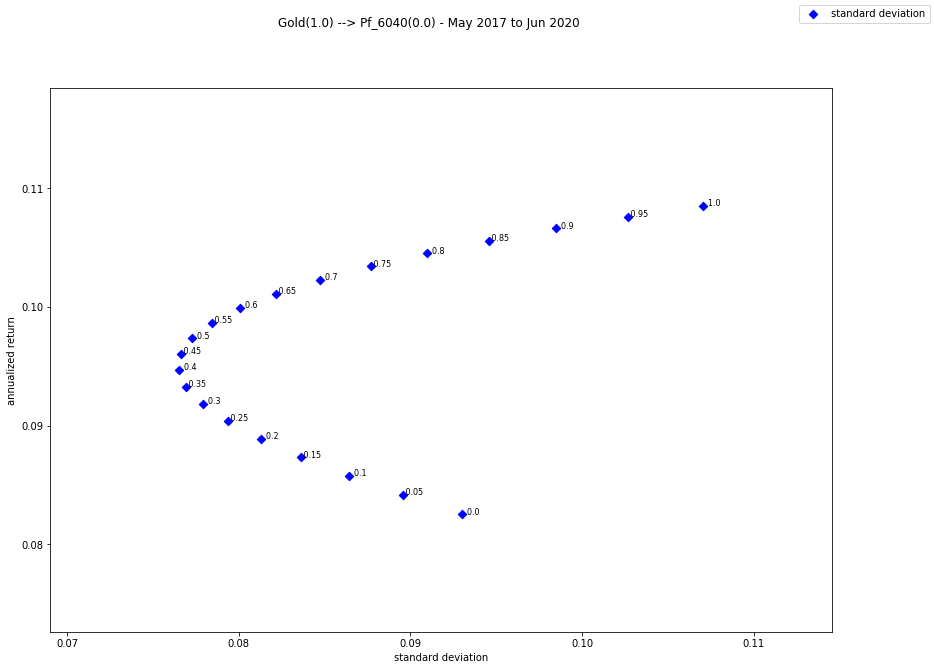

In [ ]:
plot_bullet(gold, pf_6040, 20)

Plot returns for various portfolio combinations of the pair versus the portfolio's **downside deviation**.

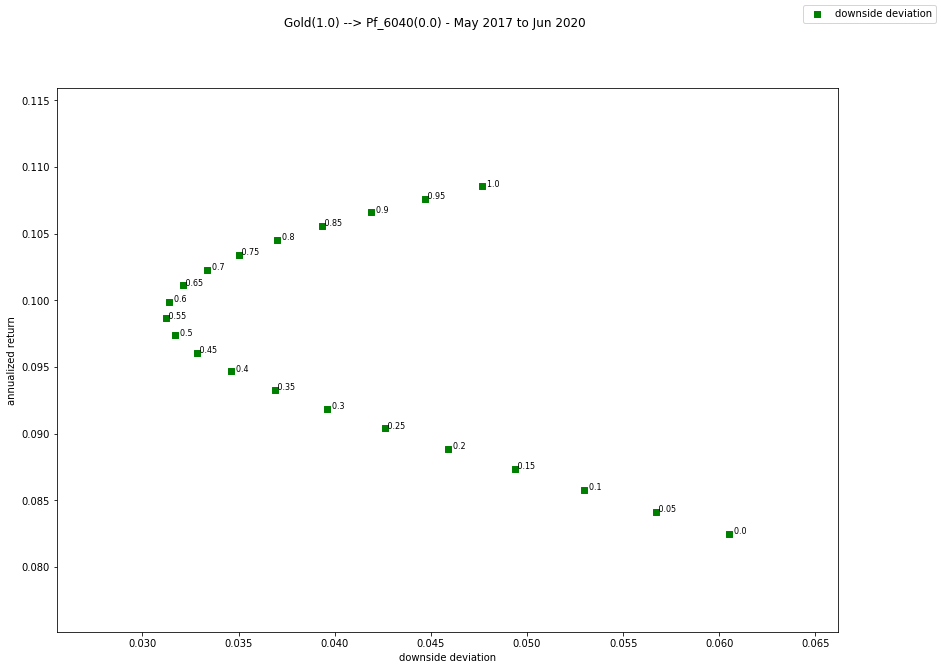

In [ ]:
plot_bullet(gold, pf_6040, 20, vol=VOL_DOWNSIDE)

Plot returns for various portfolio combinations of the pair versus the portfolios' **standard deviation AND downside deviation**.

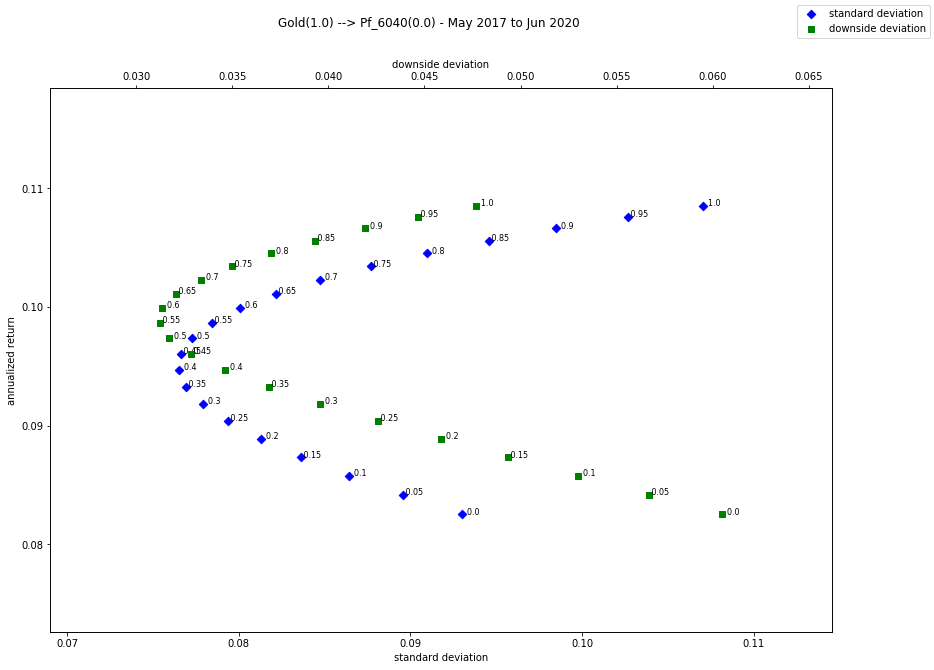

In [ ]:
plot_bullet(gold, pf_6040, 20, vol=VOL_STANDARD|VOL_DOWNSIDE)

### Window Computations

In [ ]:
#export

def window_gen(datetime_index, window_len, window_step):
    """Create a sequence of (start_date, end_date) for a fixed-width rolling window.
    
    Args:
     - datetime_index: iterable of dates that index some dataset (exptected to be at a fixed period, say weekly)
     - window_len: size of the window, expressed in number of `datetime_index1 intervals
     - window_step: number of periods to advance window on each iteration
    """
    for start_ix in range(0, len(datetime_index) - window_len + 1, window_step):
        yield(datetime_index[start_ix], datetime_index[start_ix + window_len - 1])

An example call to the `window_gen` generator.

In [ ]:
index1_list = ['2012-01', '2012-02', '2012-03', '2012-04', '2012-05' ]
index1 = pd.DataFrame(index = index1_list).index
index1

Index(['2012-01', '2012-02', '2012-03', '2012-04', '2012-05'], dtype='object')

Index length is 5; find the width 3 windows with stepsize 1

In [ ]:
wg1 = window_gen(index1, 3, 1)
assert list(wg1) == [('2012-01', '2012-03'), ('2012-02', '2012-04'), ('2012-03', '2012-05')]

With stepsize two, there are only 2 width 3 windows.

In [ ]:
wg2 = window_gen(index1, 3, 2)
assert list(wg2) == [('2012-01', '2012-03'), ('2012-03', '2012-05')]

With window_len == window_step, windows are non-overlapping. Also notice here that when step size is not equal to 1, data at the end of the series will be excluded that does not constitute a full-width window.

In [ ]:
wg3 = window_gen(index1, 2, 2)
assert list(wg3) == [('2012-01', '2012-02'), ('2012-03', '2012-04')]

-------

In [ ]:
#export

def window_stats(return_series, window_len, window_step, stat_fns):
    """Compute statistics over a rolling window of the specified return series.
    
    Args:
     - return_series: a sequence of period returns (.01 = 1% return), indexed by date
     - window_len: length of window of return series to use for computation of stats, repeatedly
     - window_step: number of periods to advance window on each iteration (`window_step` == `window_len`
     => contiguous nonoverlapping windows)
     - stat_fns: a sequence of functions, each accepts an iterable of period returns as its only arg
     
     Returns:
      - A datframe whose columns are the outputs of `stat_fns`, applied to the window at each step, and 
      indexed by the date of the last period of the window at this step. The column order corresponds to the 
      order of stat_fns.
    """
    date_list = []
    stats_list = []
    rs_len = return_series.shape[0]
    
    for start_date, end_date in window_gen(return_series.index, window_len, window_step):
        window = return_series[start_date : end_date]
        
        # compute stats on this window
        stats_list.append([fn(window) for fn in stat_fns])
        
        # date corresponding to value for the window is the last date included in the window
        date_list.append(end_date)
        
    return pd.DataFrame(stats_list, index=date_list)

Example usage of `window_stats()`. Compute stats on year long windows, every 3 months.

In [ ]:
from functools import partial

In [ ]:
stat_fns = [partial(estats.annual_return, period='monthly'), partial(estats.annual_volatility, period='monthly')]
df = window_stats(pf_6040.Pf_6040, 12, 3, stat_fns)

In [ ]:
df.columns = ['annual_return', 'annual_volatility']
df

,annual_return,annual_volatility
2018-04-01,0.071596,0.053426
2018-07-01,0.088161,0.056362
2018-10-01,0.037995,0.074464
2019-01-01,-0.001307,0.100596
2019-04-01,0.100668,0.098406
2019-07-01,0.076751,0.109930
2019-10-01,0.122824,0.097511
2020-01-01,0.156083,0.059892
2020-04-01,0.049096,0.125988


In [ ]:
pf_6040.index[-12:]

DatetimeIndex(['2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

#### Dev scratch

In [ ]:
index_fail = ['2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2017-05-01', '2017-06-01',
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01',
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01']
wg_fail = window_gen(index_fail, 12, 3)
list(wg_fail)

[('2017-05-01', '2018-04-01'),
 ('2017-08-01', '2018-07-01'),
 ('2017-11-01', '2018-10-01'),
 ('2018-02-01', '2019-01-01'),
 ('2018-05-01', '2019-04-01'),
 ('2018-08-01', '2019-07-01'),
 ('2018-11-01', '2019-10-01'),
 ('2019-02-01', '2020-01-01'),
 ('2019-05-01', '2020-04-01'),
 ('2019-08-01', '2017-05-01'),
 ('2019-11-01', '2017-08-01'),
 ('2020-02-01', '2017-11-01'),
 ('2020-05-01', '2018-02-01'),
 ('2017-06-01', '2018-05-01'),
 ('2017-09-01', '2018-08-01'),
 ('2017-12-01', '2018-11-01'),
 ('2018-03-01', '2019-02-01'),
 ('2018-06-01', '2019-05-01'),
 ('2018-09-01', '2019-08-01'),
 ('2018-12-01', '2019-11-01'),
 ('2019-03-01', '2020-02-01'),
 ('2019-06-01', '2020-05-01')]

2017-05-01 00:00:00 2018-04-01 00:00:00
2017-08-01 00:00:00 2018-07-01 00:00:00
2017-11-01 00:00:00 2018-10-01 00:00:00
2018-02-01 00:00:00 2019-01-01 00:00:00
2018-05-01 00:00:00 2019-04-01 00:00:00
2018-08-01 00:00:00 2019-07-01 00:00:00
2018-11-01 00:00:00 2019-10-01 00:00:00
2019-02-01 00:00:00 2020-01-01 00:00:00
2019-05-01 00:00:00 2020-04-01 00:00:00
2019-08-01 00:00:00 2017-05-01 00:00:00

In [ ]:
period='monthly'
window_len=12
window_step=3
return_series = pf_6040.Pf_6040
rs_len = return_series.shape[0]
rs_len

38

Final index of the window is chosen so that there are `window` more values remaining. If window_step is > 1, this can mean that some values at the end are not used.

In [ ]:
list(range(0, rs_len - window_len, window_step))

[0, 3, 6, 9, 12, 15, 18, 21, 24]

In [ ]:
return_list = []
vol_list = []
date_list = []
for start_ix in range(0, rs_len - window_len, window_step):
    window = return_series.iloc[start_ix : start_ix + window_len]
    return_list.append(estats.annual_return(window.values, period=period))
    vol_list.append(estats.annual_volatility(window.values, period=period))
    # date corresponding to value for the window is the last date included in the window
    date_list.append(return_series.index[start_ix + window_len - 1].date())
    
print(return_list)
print(date_list)

[0.07159592315354191, 0.08816056895858226, 0.03799535104134821, -0.001307454275117359, 0.10066832877977916, 0.07675104136527655, 0.12282406820585123, 0.15608320260741881, 0.0490961861831114]
[datetime.date(2018, 4, 1), datetime.date(2018, 7, 1), datetime.date(2018, 10, 1), datetime.date(2019, 1, 1), datetime.date(2019, 4, 1), datetime.date(2019, 7, 1), datetime.date(2019, 10, 1), datetime.date(2020, 1, 1), datetime.date(2020, 4, 1)]


Note that the first date in `date_list` aligns with the last row in the first window:

In [ ]:
return_series.iloc[:12]

Date
2017-05-01    0.010199
2017-06-01   -0.000358
2017-07-01    0.016895
2017-08-01    0.004765
2017-09-01    0.005867
2017-10-01    0.016573
2017-11-01    0.017876
2017-12-01    0.002655
2018-01-01    0.033965
2018-02-01   -0.023838
2018-03-01   -0.016067
2018-04-01    0.002121
Name: Pf_6040, dtype: float64

In [ ]:
return_series.loc['2017-05-01':'2017-07-01']

Date
2017-05-01    0.010199
2017-06-01   -0.000358
2017-07-01    0.016895
Name: Pf_6040, dtype: float64

In [ ]:
return_series.loc['2017-05-01']

0.010198633328768691

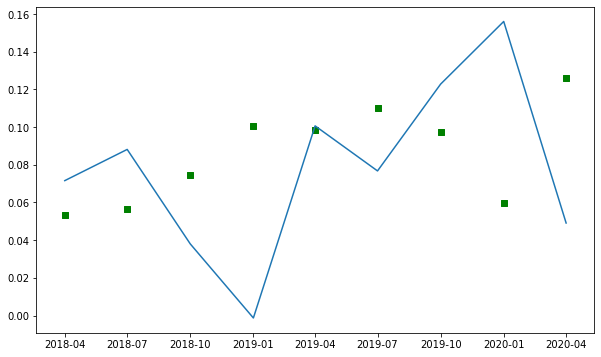

In [ ]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
plt.plot(date_list, return_list);
plt.scatter(date_list, vol_list, marker="s", c='g')

## Optimal Asset Combo Window Computations

In [ ]:
#export
def rolling_optimal_combo_stats(ret1, ret2, window_len, window_step, nsteps=20, period='monthly', rebal_period=3,
                               downside_vol=True):
    """Find the optimal (volatility-minimizing) combination of two return series over a rolling window.
    
    Args:
     - ret1: a sequence of period returns (.01 = 1% return), indexed by date
     - ret2: a sequence of period returns (.01 = 1% return), indexed by date
     - window_len: length of window of return series to use for computation of stats, repeatedly
     - window_step: number of periods to advance window on each iteration (`window_step` == `window_len`
     => contiguous nonoverlapping windows)
     - nsteps: divide toe [0.0, 1.0] interval into this many steps in the search for the min vol combination
     - period: return interval in `ret1`, `ret2`: {'daily', 'weekly', 'monthly'}
     - rebal_period: interval for rebalancing the allocation; expressed as number of periods of type `period`
     - downside_vol: If true, use downside deviation as volatility metric, else standard deviation
    
    Return:
     - DataFrame containing portfolio performance stats for the optimal portfolio over each window.
    """
    # column name of chosen volatility metric
    vol_column = 'downside_dev' if downside_vol else 'standard_dev'
    
    # find the inner-joined indices of the two return series
    joined_index = pd.concat([ret1, ret2], axis=1, join='inner').index
    
    #print(joined_index)
    
    data = []
    dates = []
    for start_date, end_date in window_gen(joined_index, window_len, window_step):
        
        df, _ = ret_vol_combos(ret1[start_date:end_date], ret2[start_date:end_date], nsteps, period, rebal_period)
        
        # pick "optimal" portfolio -- choose one with minimum volatility (could use std or downside)
        # index of row with lowest value for downside_dev
        best_row_idx = sorted(enumerate(df.downside_dev), key=lambda x: x[1])[0][0]
        
        data.append(df.iloc[best_row_idx])
        dates.append(end_date)
        
    return pd.DataFrame(data, index=dates)

Example call to `rolling_optimal_combo_stats().`

In [ ]:
optimal_stats = rolling_optimal_combo_stats(gold, pf_6040, 12, 3)
optimal_stats.head()

,w1,ann_ret,standard_dev,downside_dev
2018-04-01,0.25,0.061628,0.051864,0.026310
2018-07-01,0.20,0.062506,0.051739,0.026849
2018-10-01,0.50,-0.003109,0.050251,0.030846
2019-01-01,0.50,-0.009917,0.054091,0.030850
2019-04-01,0.50,0.037989,0.048794,0.020418


In [ ]:
optimal_stats.tail()

,w1,ann_ret,standard_dev,downside_dev
2019-04-01,0.5,0.037989,0.048794,0.020418
2019-07-01,0.6,0.121595,0.072490,0.008260
2019-10-01,0.5,0.181368,0.076936,0.016057
2020-01-01,0.4,0.174450,0.066432,0.015652
2020-04-01,0.7,0.227943,0.120308,0.038281


### Dev Scratch

In [ ]:
df, date_range = ret_vol_combos(pf_6040, gold, 10)
df.head()

,w1,ann_ret,standard_dev,downside_dev
0,1.0,0.082506,0.093022,0.060488
1,0.9,0.085765,0.086408,0.052984
2,0.8,0.088882,0.081268,0.045876
3,0.7,0.091856,0.077895,0.039586
4,0.6,0.094685,0.076527,0.034601


In [ ]:
row4 = df.iloc[4]
row4

w1              0.600000
ann_ret         0.094685
standard_dev    0.076527
downside_dev    0.034601
Name: 4, dtype: float64

In [ ]:
row4.values

array([0.6       , 0.09468505, 0.07652684, 0.03460073])

In [ ]:
data = [df.iloc[4], df.iloc[3]]

In [ ]:
pd.DataFrame(data)

,w1,ann_ret,standard_dev,downside_dev
4,0.6,0.094685,0.076527,0.034601
3,0.7,0.091856,0.077895,0.039586


In [ ]:
type(df.iloc[4])

pandas.core.series.Series

In [ ]:
sorted_sd = sorted(enumerate(df.standard_dev), key=lambda x: x[1])
sorted_sd

[(4, 0.0765268410551348),
 (5, 0.07727163751513509),
 (3, 0.0778954490381338),
 (6, 0.08007450604070476),
 (2, 0.08126796998024934),
 (7, 0.08473561500152263),
 (1, 0.08640819651660174),
 (8, 0.09097433905184177),
 (0, 0.09302248375269594),
 (9, 0.0984961928247948),
 (10, 0.10703604233004647)]

In [ ]:
sorted_sd[0][0]

4

In [ ]:
list(enumerate(df.standard_dev))

[(0, 0.09302248375269594),
 (1, 0.08640819651660174),
 (2, 0.08126796998024934),
 (3, 0.0778954490381338),
 (4, 0.0765268410551348),
 (5, 0.07727163751513509),
 (6, 0.08007450604070476),
 (7, 0.08473561500152263),
 (8, 0.09097433905184177),
 (9, 0.0984961928247948),
 (10, 0.10703604233004647)]

# Notebook Export

In [ ]:
#hide
notebook2script()

Converted 00_core.ipynb.
Converted 01_Stats.ipynb.
Converted index.ipynb.
